## Forecasting Retail Sales

In [3]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss

In [4]:
file_path = "data/alpha_vantage/retail_sales.json"

with open(file_path, "r") as f:
    data = json.load(f)

In [5]:
df = pd.DataFrame(data["data"])
df["date"] = pd.to_datetime(df["date"])
df["value"] = pd.to_numeric(df["value"])
df.set_index("date", inplace=True)
df = df.sort_index()

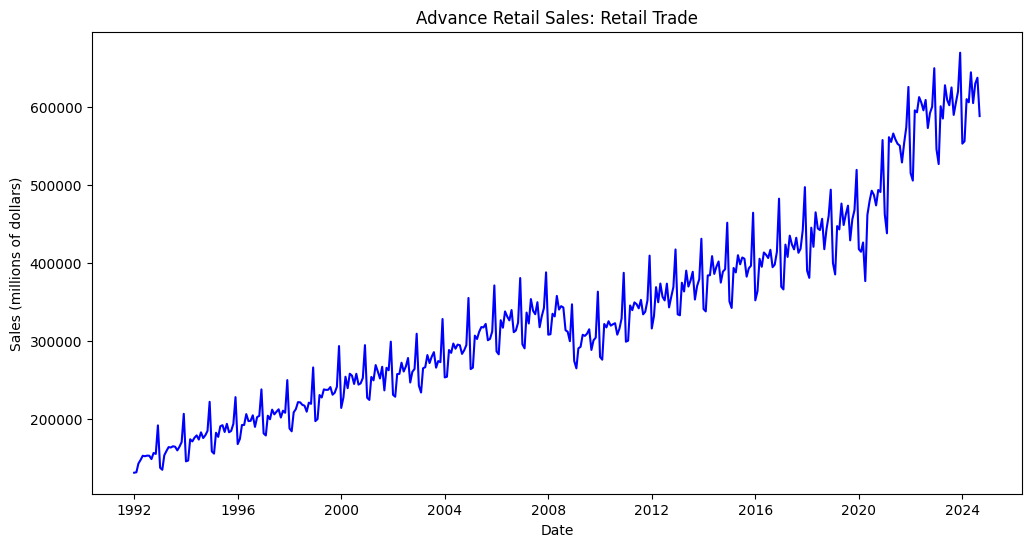

In [6]:
plt.figure(figsize=(12, 6))
plt.plot(df["value"], color="blue")
plt.title("Advance Retail Sales: Retail Trade")
plt.xlabel("Date")
plt.ylabel("Sales (millions of dollars)")
plt.show()

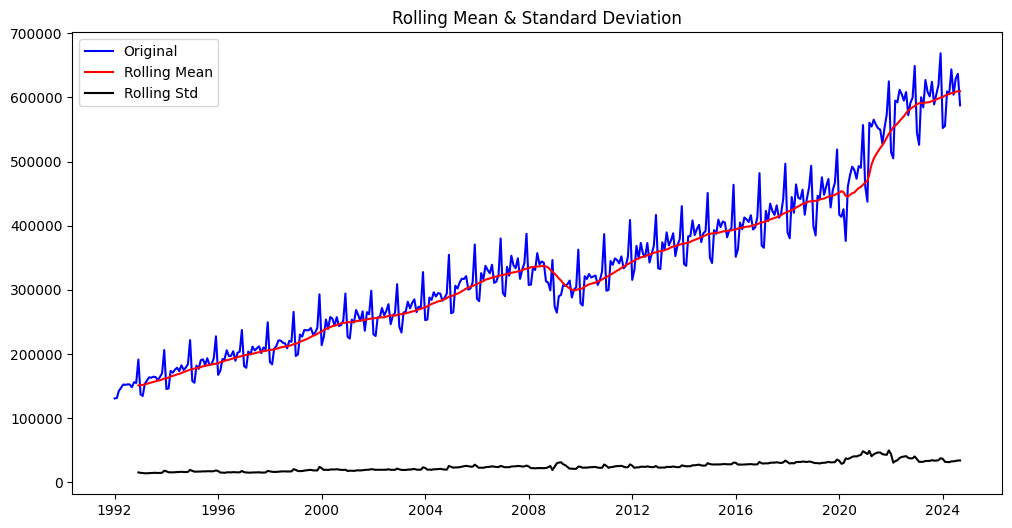

In [7]:

rolling_window = 12  # Monthly data, so a 12-month rolling window
df["Rolling Mean"] = df["value"].rolling(window=rolling_window).mean()
df["Rolling Std"] = df["value"].rolling(window=rolling_window).std()

plt.figure(figsize=(12, 6))
plt.plot(df["value"], color="blue", label="Original")
plt.plot(df["Rolling Mean"], color="red", label="Rolling Mean")
plt.plot(df["Rolling Std"], color="black", label="Rolling Std")
plt.title("Rolling Mean & Standard Deviation")
plt.legend()
plt.show()

#### Removing trends

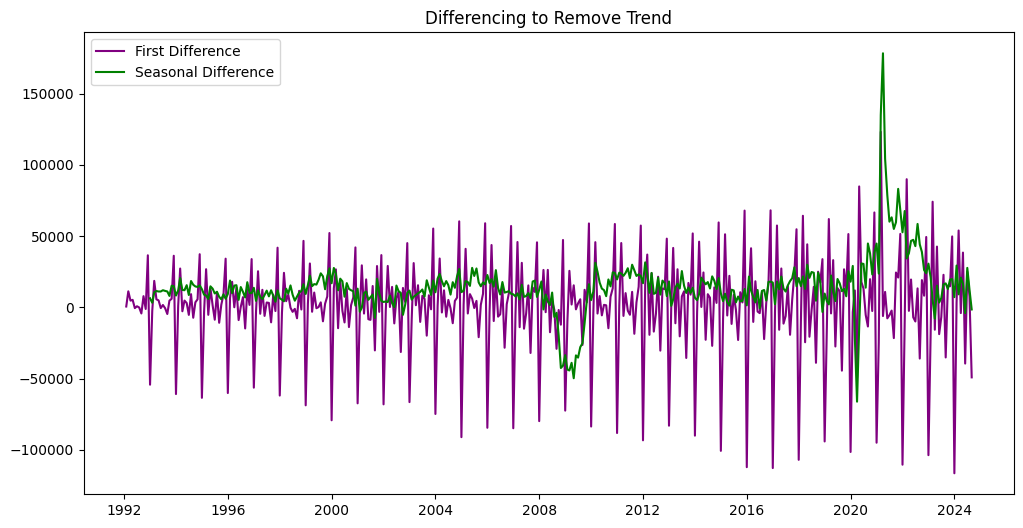

In [8]:
df["First Difference"] = df["value"].diff()
df["Seasonal Difference"] = df["value"].diff(
    rolling_window
)  # Seasonal differencing for 12-month seasonality

plt.figure(figsize=(12, 6))
plt.plot(df["First Difference"], color="purple", label="First Difference")
plt.plot(df["Seasonal Difference"], color="green", label="Seasonal Difference")
plt.title("Differencing to Remove Trend")
plt.legend()
plt.show()

#### Checking for stationarity

In [9]:
# Stationarity Tests
# Augmented Dickey-Fuller Test
def adf_test(series):
    result = adfuller(series.dropna())
    print("ADF Test:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    for key, value in result[4].items():
        print(f"Critical Value {key}: {value}")
    if result[1] < 0.05:
        print("Conclusion: Reject the null hypothesis. Data is stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis. Data is non-stationary.")


# KPSS Test
def kpss_test(series):
    result = kpss(series.dropna(), regression="c")
    print("\nKPSS Test:")
    print(f"KPSS Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    for key, value in result[3].items():
        print(f"Critical Value {key}: {value}")
    if result[1] < 0.05:
        print("Conclusion: Reject the null hypothesis. Data is non-stationary.")
    else:
        print("Conclusion: Fail to reject the null hypothesis. Data is stationary.")


print("\n--- ADF Test on Original Data ---")
adf_test(df["value"])
print("\n--- KPSS Test on Original Data ---")
kpss_test(df["value"])

print("\n--- ADF Test on First Differenced Data ---")
adf_test(df["First Difference"])
print("\n--- KPSS Test on First Differenced Data ---")
kpss_test(df["First Difference"])

print("\n--- ADF Test on Seasonally Differenced Data ---")
adf_test(df["Seasonal Difference"])
print("\n--- KPSS Test on Seasonally Differenced Data ---")
kpss_test(df["Seasonal Difference"])


--- ADF Test on Original Data ---
ADF Test:
ADF Statistic: 0.8241873366927099
p-value: 0.9920167330188467
Critical Value 1%: -3.4478619826418817
Critical Value 5%: -2.869257669826291
Critical Value 10%: -2.570881358363513
Conclusion: Fail to reject the null hypothesis. Data is non-stationary.

--- KPSS Test on Original Data ---

KPSS Test:
KPSS Statistic: 3.1157002586276104
p-value: 0.01
Critical Value 10%: 0.347
Critical Value 5%: 0.463
Critical Value 2.5%: 0.574
Critical Value 1%: 0.739
Conclusion: Reject the null hypothesis. Data is non-stationary.

--- ADF Test on First Differenced Data ---
ADF Test:
ADF Statistic: -3.9925599804286014
p-value: 0.0014499743678379595
Critical Value 1%: -3.4478619826418817
Critical Value 5%: -2.869257669826291
Critical Value 10%: -2.570881358363513
Conclusion: Reject the null hypothesis. Data is stationary.

--- KPSS Test on First Differenced Data ---

KPSS Test:
KPSS Statistic: 0.14294482764419733
p-value: 0.1
Critical Value 10%: 0.347
Critical Valu

/var/folders/vv/27_476013ls6_cwg052s2mt40000gn/T/ipykernel_21995/328047054.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(series.dropna(), regression="c")
/var/folders/vv/27_476013ls6_cwg052s2mt40000gn/T/ipykernel_21995/328047054.py:18: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(series.dropna(), regression="c")


#### Looking for autocorrelation between data

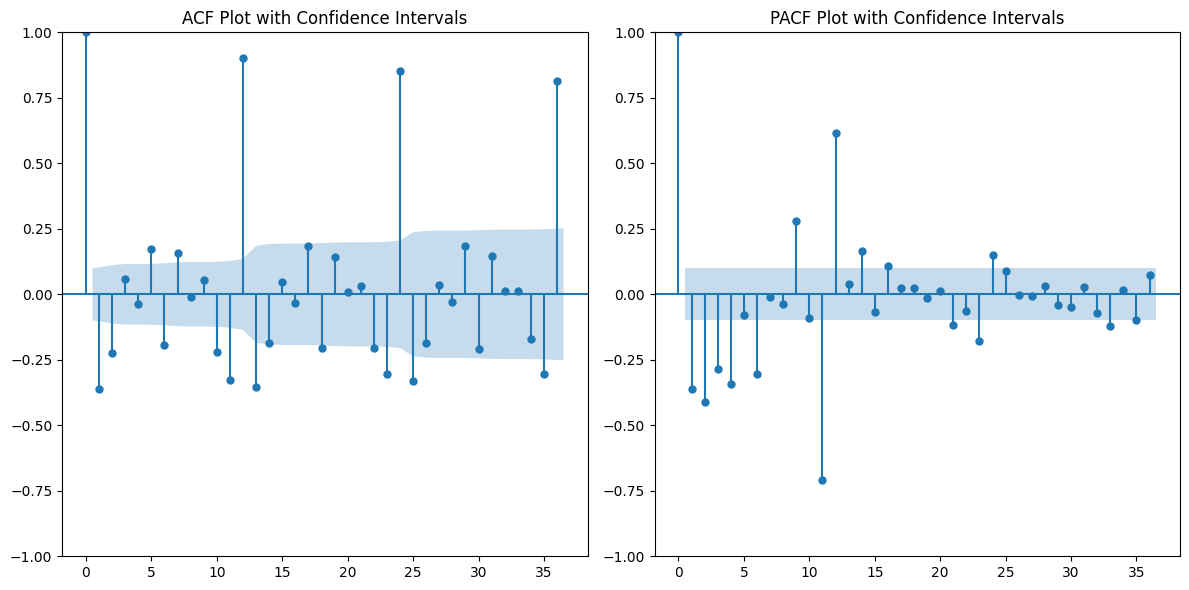

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.figure(figsize=(12, 6))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(
    df["Seasonal Difference"].dropna(), lags=36, ax=plt.gca(), alpha=0.05
)  # Confidence interval at 95%
plt.title("ACF Plot with Confidence Intervals")

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(
    df["Seasonal Difference"].dropna(), lags=36, ax=plt.gca(), alpha=0.05
)  # Confidence interval at 95%
plt.title("PACF Plot with Confidence Intervals")

plt.tight_layout()
plt.show()

- The observation that the ACF and PACF plots show significant spikes at 12-month intervals indicates the presence of seasonality in your time series data, *even after first differencing*. This suggests that there are seasonal patterns in our data that persist beyond the immediate trend removal.

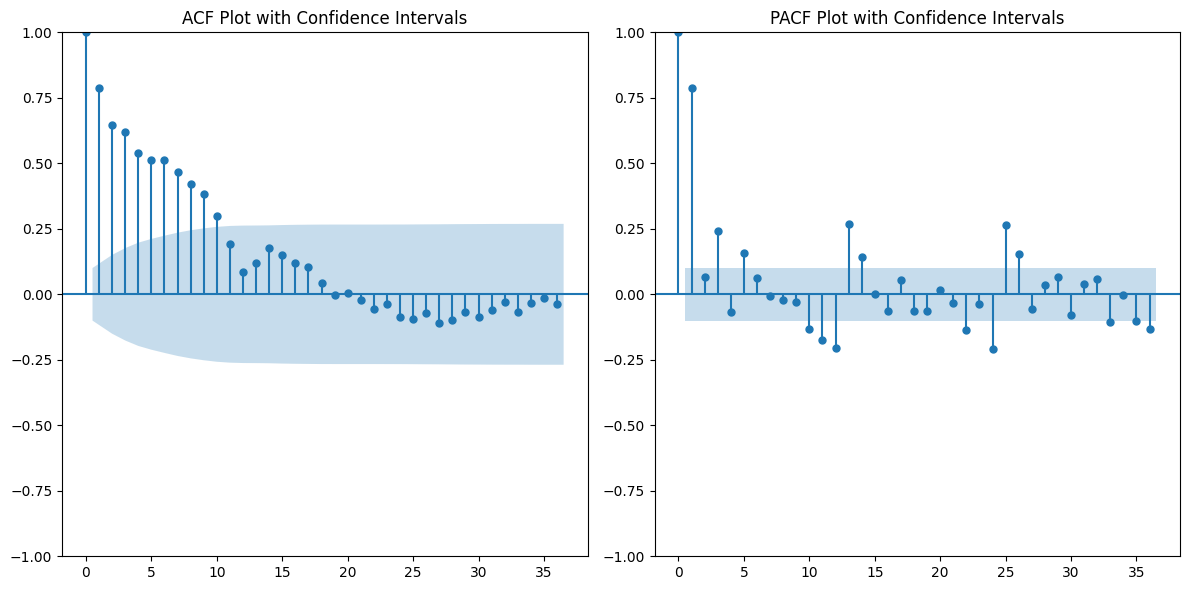

In [16]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(
    df["Seasonal Difference"].dropna(), lags=36, ax=plt.gca(), alpha=0.05
)  
plt.title("ACF Plot with Confidence Intervals")

plt.subplot(1, 2, 2)
plot_pacf(
    df["Seasonal Difference"].dropna(), lags=36, ax=plt.gca(), alpha=0.05
)  
plt.title("PACF Plot with Confidence Intervals")

plt.tight_layout()
plt.show()

1. ACF
- Shows significant spikes only for the first few lags (e.g., up to 10 lags) and then falls within the confidence interval (CI) thereafter, this indicates that the autocorrelation is primarily short-range and that the series may be well represented by an ARMA component without the need for higher-order terms.
- Seasonal differencing has effectively removed most of the long-range dependencies from the data, and you are likely dealing with a stationary series.

2. PACF
- The sinusoidal wave pattern in the PACF suggests that there may still be some periodic (seasonal) influences left in the data, even after seasonal differencing. This can occur in time series where the underlying data exhibit oscillations or cycles.
- The sin wave pattern typically indicates that the correlation at each lag is oscillating between positive and negative values, which is a common characteristic of time series that have some periodic structure.

#### Removing seasonality and trend both

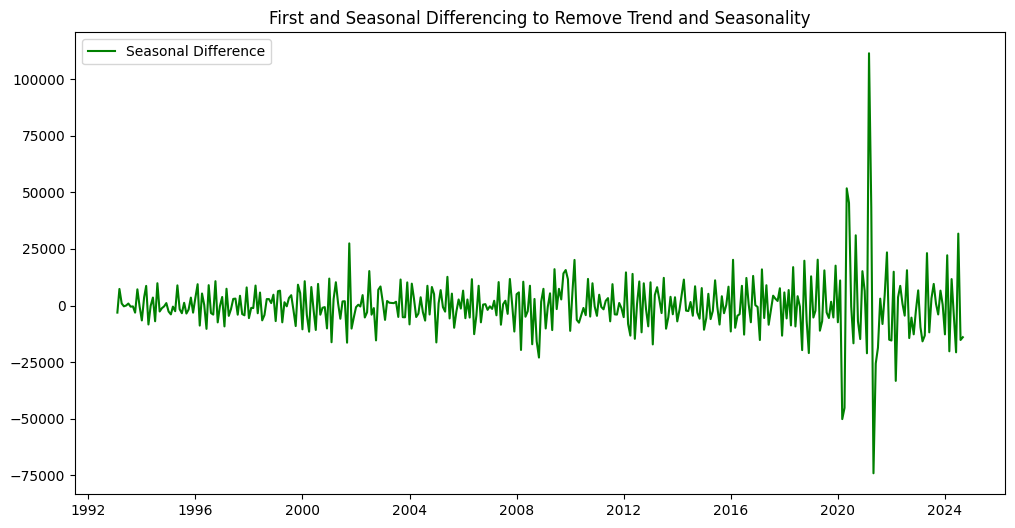

In [20]:
df["Seasonal over First Difference"] = df["First Difference"].diff(
    rolling_window
)  # Seasonal differencing the first difference for 12-month seasonality to remove trend and seasonality both

plt.figure(figsize=(12, 6))
plt.plot(
    df["Seasonal over First Difference"], color="green", label="Seasonal Difference"
)
plt.title("First and Seasonal Differencing to Remove Trend and Seasonality")
plt.legend()
plt.show()

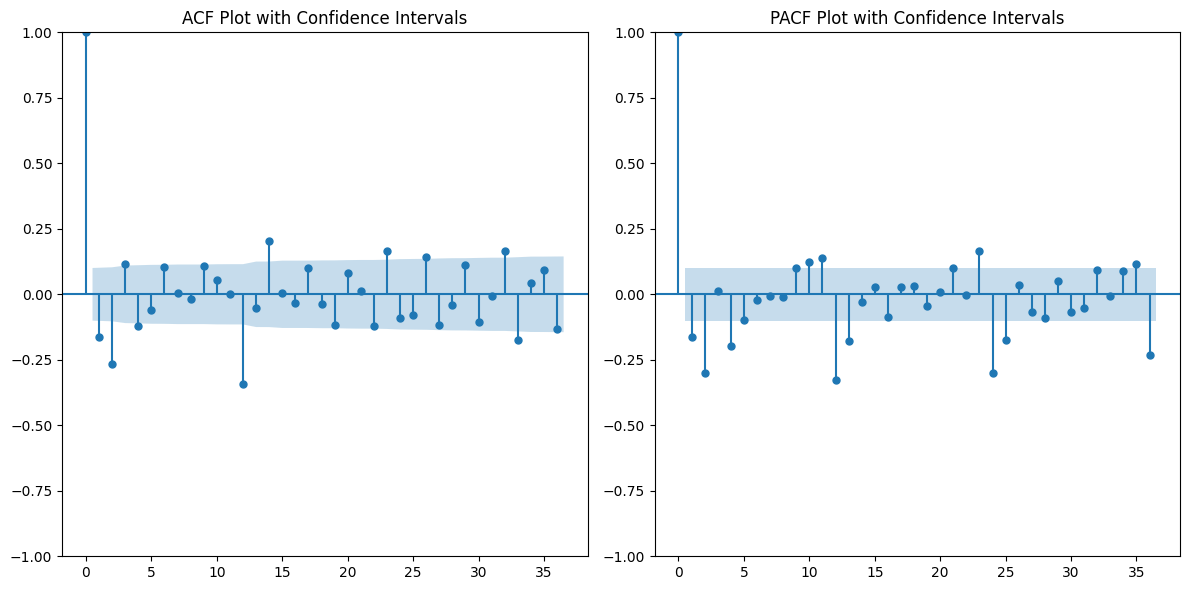

In [21]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plot_acf(
    df["Seasonal over First Difference"].dropna(), lags=36, ax=plt.gca(), alpha=0.05
)
plt.title("ACF Plot with Confidence Intervals")

plt.subplot(1, 2, 2)
plot_pacf(
    df["Seasonal over First Difference"].dropna(), lags=36, ax=plt.gca(), alpha=0.05
)
plt.title("PACF Plot with Confidence Intervals")

plt.tight_layout()
plt.show()

- The quick drop to inside the confidence interval indicates that most of the autocorrelation in our data has been accounted for after applying both differencing techniques.
- The fact that spikes occasionally go slightly outside the confidence interval suggests there may still be very minor patterns or noise remaining, but they are not significant enough to indicate strong autocorrelation.


In [22]:
from pmdarima import auto_arima

model = auto_arima(
    df["Seasonal over First Difference"].dropna(),
    seasonal=False,  # Since we've already removed both trend and seasonal effects
    stepwise=True,
    suppress_warnings=True,
    trace=True,
)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=8201.026, Time=0.10 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=8258.410, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=8250.351, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=8238.232, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=8205.459, Time=0.02 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=8216.978, Time=0.02 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=inf, Time=0.08 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=inf, Time=0.12 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=8221.808, Time=0.02 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=8199.028, Time=0.05 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=8206.896, Time=0.02 sec
 ARIMA(1,0,4)(0,0,0)[0]             : AIC=8207.610, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=8207.240, Time=0.01 sec
 ARIMA(0,0,4)(0,0,0)[0]             : AIC=8205.703, Time=0.02 sec
 ARIMA(2,0,4)(0,0,0)[0]             : AIC=i

#### Key Metrics

- **Best Model**: ARIMA(1,0,3)
- **AIC**: 8199.028  
  The AIC value indicates the quality of the model; lower values suggest a better fit.

#### Model Specifications
- **Dependent Variable**: The response variable (y) being predicted.
- **Number of Observations**: 380  
  This indicates the total data points used to fit the model.

#### Log Likelihood
- **Log Likelihood**: -4094.514  
  A higher log likelihood indicates a better fit.

#### Information Criteria
- **BIC**: 8218.729  
- **HQIC**: 8206.846  
  These values also help evaluate the model's fit, with lower values being preferable.


#### Interpretation of Coefficients
- **ar.L1 (-0.8861)**: This indicates a strong negative correlation with the previous observation. The high z-score and low p-value (0.000) imply that this coefficient is statistically significant.
- **ma.L1 (0.6969)**, **ma.L2 (-0.5306)**, **ma.L3 (-0.2435)**: These moving average terms also show significant effects, with the first two being positively and negatively correlated, respectively.
- **sigma2 (1.422e+08)**: Represents the variance of the error term in the model. 

#### Diagnostics

1. Ljung-Box Test
- **Ljung-Box Q (L1)**: 0.02  
- **Prob(Q)**: 0.88  
  This test checks for autocorrelation in the residuals. A high p-value (>0.05) indicates that residuals are uncorrelated, suggesting a good fit.

2. Jarque-Bera Test
- **Jarque-Bera (JB)**: 11883.25  
- **Prob(JB)**: 0.00  
  This test checks for normality in the residuals. A low p-value indicates that the residuals are not normally distributed.

3. Heteroskedasticity Test
- **Heteroskedasticity (H)**: 9.41  
- **Prob(H) (two-sided)**: 0.00  
  Indicates that there is significant heteroskedasticity in the model, suggesting that the variance of the errors is not constant.

4. Skewness and Kurtosis
- **Skew**: 2.53  
- **Kurtosis**: 29.92  
  High skewness suggests asymmetry in the residuals, and high kurtosis indicates heavy tails.

5. Warnings
1. **Covariance matrix calculated using the outer product of gradients (complex-step)**: This warning indicates that the covariance matrix may not be robust.
2. **Covariance matrix is singular or near-singular, with condition number \(2 \times 10^{33}\)**: This implies potential instability in the estimation of standard errors.


The ARIMA(1,0,3) model is evidently the best fit based on the AIC criterion. The diagnostics suggest that while the model fits well in terms of autocorrelation, the residuals are not normally distributed and exhibit heteroskedasticity. Caution should be exercised in interpreting the results due to potential instability in standard errors, as indicated by the warnings.


Fitted ARIMA(0, 0, 0) | AIC: 10138.674062890464
Fitted ARIMA(0, 0, 1) | AIC: 8240.23262192991
Fitted ARIMA(0, 0, 2) | AIC: 8209.245376890043
Fitted ARIMA(0, 0, 3) | AIC: 8208.90062809586
Fitted ARIMA(0, 0, 4) | AIC: 8207.709742387997
Fitted ARIMA(0, 0, 5) | AIC: 8209.552112721947
Fitted ARIMA(0, 0, 6) | AIC: 8208.207640554592
Fitted ARIMA(0, 0, 7) | AIC: 8210.836022892274
Fitted ARIMA(0, 0, 8) | AIC: 8186.588085786319
Fitted ARIMA(0, 0, 9) | AIC: 8187.861156390998
Fitted ARIMA(0, 0, 10) | AIC: 8178.943266892347
Fitted ARIMA(1, 0, 0) | AIC: 8252.350516887218
Fitted ARIMA(1, 0, 1) | AIC: 8223.813092467171
Fitted ARIMA(1, 0, 2) | AIC: 8207.463587372995
Fitted ARIMA(1, 0, 3) | AIC: 8201.033148353063
Fitted ARIMA(1, 0, 4) | AIC: 8209.61572885639
Fitted ARIMA(1, 0, 5) | AIC: 8203.447178954946
Fitted ARIMA(1, 0, 6) | AIC: 8210.066847714465
Fitted ARIMA(1, 0, 7) | AIC: 8186.160853206174
Fitted ARIMA(1, 0, 8) | AIC: 8181.736073150907
Fitted ARIMA(1, 0, 9) | AIC: 8178.148230015234
Fitted ARIMA(1

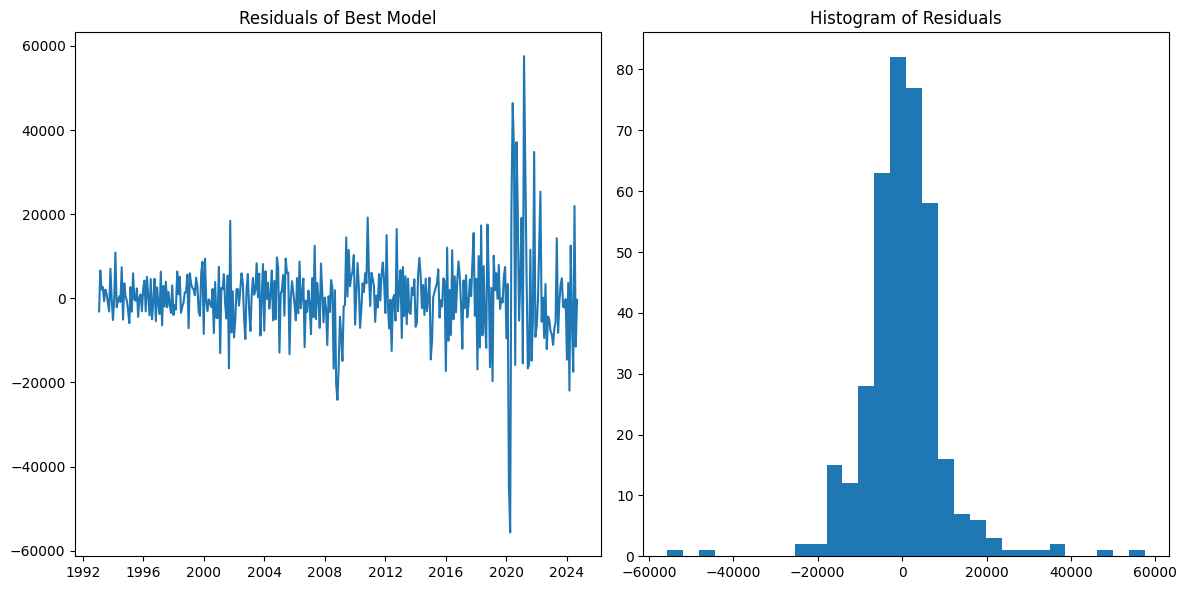

In [93]:
from statsmodels.tsa.arima.model import ARIMA

import warnings

warnings.filterwarnings("ignore", category=UserWarning)

seasonal_diff_data = df["Seasonal over First Difference"].dropna()

p_range = range(0, 11)  # p from 0 to 10
q_range = range(0, 11)  # q from 0 to 10
best_aic = float("inf")
best_order = (0, 0, 0)
best_model = None

for p in p_range:
    for q in q_range:
        try:
            model = ARIMA(
                seasonal_diff_data, order=(p, 0, q)
            )  # d is 0 since we already differenced the series
            model_fit = model.fit()
            aic = model_fit.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, 0, q)
                best_model = model_fit

            print(f"Fitted ARIMA({p}, 0, {q}) | AIC: {aic}")

        except Exception as e:
            print(f"Could not fit ARIMA({p}, 0, {q}): {e}")

print(f"Best ARIMA order: {best_order} with AIC: {best_aic}")
print(best_model.summary())

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(best_model.resid)
plt.title("Residuals of Best Model")
plt.subplot(1, 2, 2)
plt.hist(best_model.resid, bins=30)
plt.title("Histogram of Residuals")
plt.tight_layout()
plt.show()


#### The discrepancy between the ARIMA parameters obtained from grid search (5, 0, 10) and those suggested by auto ARIMA (1, 0, 3) can be attributed to differences in optimization approaches. Auto ARIMA employs an automated process, evaluating various combinations and leveraging criteria like AIC or BIC to identify a parsimonious model that balances complexity and fit. In contrast, the grid search method exhaustively tests a wider parameter space, which may uncover a more complex model that better captures underlying patterns in the data. Ultimately, the grid search may yield a model that fits the training data more closely, while auto ARIMA emphasizes simplicity and generalization.

#### The residuals form a roughly normal distribution, it suggests that the model has captured the underlying patterns in the data reasonably well, as normality of residuals is an assumption for many time series models. However, vague normality may also indicate the presence of some non-random patterns or residual autocorrelation, suggesting that the model might still be missing certain dynamics in the data. Further analysis, such as statistical tests for normality and autocorrelation, is necessary to validate the model's performance comprehensively.

#### Evaluation

In [107]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


seasonal_diff_data = df["Seasonal over First Difference"].dropna()

train_data = seasonal_diff_data[:-12]
test_data = seasonal_diff_data[-12:]  # Last 12 months for testing

model = ARIMA(train_data, order=(5, 0, 10))
model_fit = model.fit()
print(model_fit.summary())

                                     SARIMAX Results                                      
Dep. Variable:     Seasonal over First Difference   No. Observations:                  368
Model:                            ARIMA(5, 0, 10)   Log Likelihood               -3916.157
Date:                            Sun, 27 Oct 2024   AIC                           7866.314
Time:                                    19:10:23   BIC                           7932.751
Sample:                                02-01-1993   HQIC                          7892.709
                                     - 09-01-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         28.4349    114.953      0.247      0.805    -196.868     253.738
ar.L1          0.8014      0.078   

In [108]:
predicted_values = model_fit.forecast(steps=12)

# Create a DataFrame to compare actual vs predicted
combined_df = pd.DataFrame(
    {
        "Actual": test_data.values,
        "Predicted": predicted_values,
    },
    index=test_data.index,
)

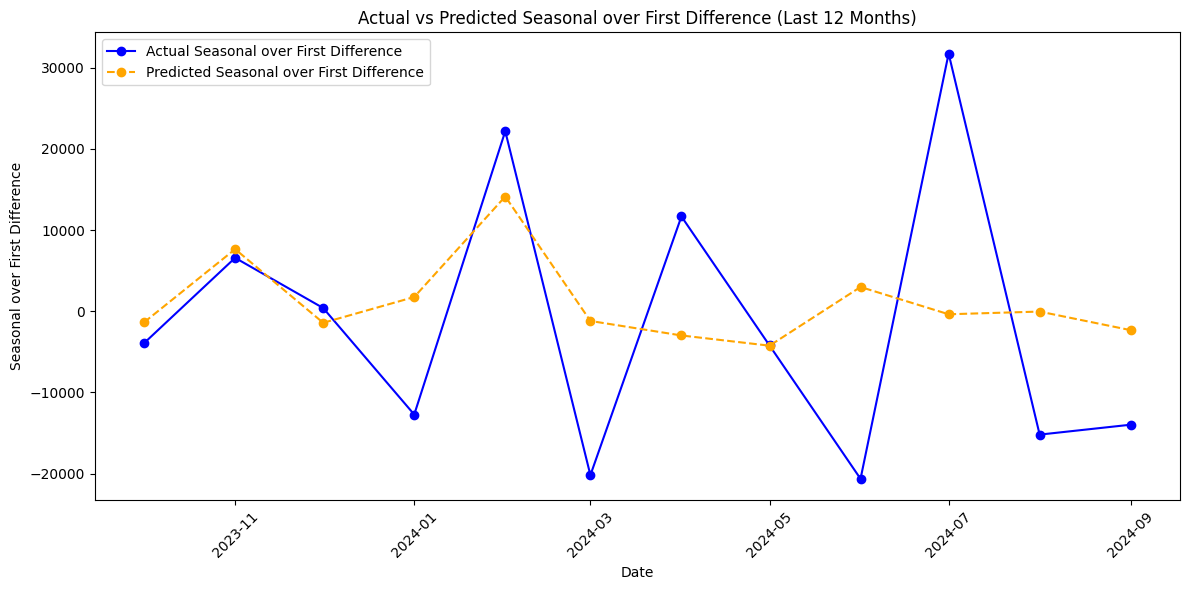

In [109]:
plt.figure(figsize=(12, 6))
plt.plot(
    combined_df.index,
    combined_df["Actual"],
    label="Actual Seasonal over First Difference",
    color="blue",
    marker="o",
)
plt.plot(
    combined_df.index,
    combined_df["Predicted"],
    label="Predicted Seasonal over First Difference",
    color="orange",
    marker="o",
    linestyle="--",
)
plt.title("Actual vs Predicted Seasonal over First Difference (Last 12 Months)")
plt.xlabel("Date")
plt.ylabel("Seasonal over First Difference")
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.legend()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

#### Forecasting future

In [110]:
seasonal_diff_data = df["Seasonal over First Difference"].dropna()

model = ARIMA(seasonal_diff_data, order=(5, 0, 10))
model_fit = model.fit()
print(model_fit.summary())

n_forecast_steps = 12
forecast = model_fit.get_forecast(steps=n_forecast_steps)

predicted_values = forecast.predicted_mean
conf_int = forecast.conf_int()

forecast_index = pd.date_range(
    start=seasonal_diff_data.index[-1] + pd.DateOffset(months=1),
    periods=n_forecast_steps,
    freq="MS",
)

                                     SARIMAX Results                                      
Dep. Variable:     Seasonal over First Difference   No. Observations:                  380
Model:                            ARIMA(5, 0, 10)   Log Likelihood               -4047.188
Date:                            Sun, 27 Oct 2024   AIC                           8128.375
Time:                                    19:13:45   BIC                           8195.358
Sample:                                02-01-1993   HQIC                          8154.954
                                     - 09-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -20.6314    169.904     -0.121      0.903    -353.637     312.375
ar.L1          0.7732      0.079   

In [ ]:
# predicted values in the differenced scale
predicted_df = pd.DataFrame(
    predicted_values.values, index=forecast_index, columns=["Predicted"]
)

# last 24 months of actual seasonal differenced data
last_24_months_actual = seasonal_diff_data.last("24M")

combined_df = pd.DataFrame({"Seasonal over First Difference": last_24_months_actual})

combined_df = combined_df.join(predicted_df, how="outer")

/var/folders/vv/27_476013ls6_cwg052s2mt40000gn/T/ipykernel_21995/2449949726.py:13: FutureWarning: last is deprecated and will be removed in a future version. Please create a mask and filter using `.loc` instead
  last_24_months_actual = seasonal_diff_data.last("24M")
/var/folders/vv/27_476013ls6_cwg052s2mt40000gn/T/ipykernel_21995/2449949726.py:13: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  last_24_months_actual = seasonal_diff_data.last("24M")


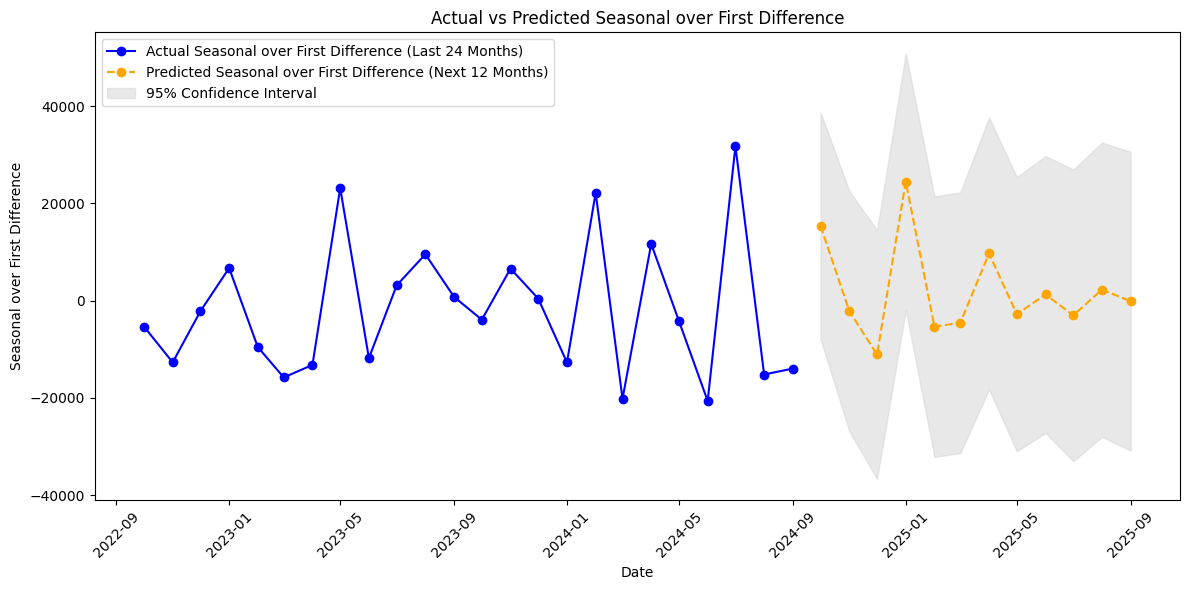

Last 24 Months of Seasonal over First Difference Values:
date
2022-10-01    -5338.0
2022-11-01   -12707.0
2022-12-01    -2163.0
2023-01-01     6698.0
2023-02-01    -9569.0
2023-03-01   -15806.0
2023-04-01   -13235.0
2023-05-01    23137.0
2023-06-01   -11830.0
2023-07-01     3140.0
2023-08-01     9538.0
2023-09-01      767.0
2023-10-01    -3926.0
2023-11-01     6582.0
2023-12-01      394.0
2024-01-01   -12728.0
2024-02-01    22187.0
2024-03-01   -20196.0
2024-04-01    11679.0
2024-05-01    -4216.0
2024-06-01   -20647.0
2024-07-01    31748.0
2024-08-01   -15201.0
2024-09-01   -13980.0
Name: Seasonal over First Difference, dtype: float64


In [106]:
# actual vs predicted in the differenced scale
plt.figure(figsize=(12, 6))
plt.plot(
    combined_df.index,
    combined_df["Seasonal over First Difference"],
    label="Actual Seasonal over First Difference (Last 24 Months)",
    color="blue",
    marker="o",
)
plt.plot(
    combined_df.index,
    combined_df["Predicted"],
    label="Predicted Seasonal over First Difference (Next 12 Months)",
    color="orange",
    marker="o",
    linestyle="--",
)

# align confidence intervals with the forecast index
plt.fill_between(
    forecast_index,
    conf_int.iloc[:, 0].values,
    conf_int.iloc[:, 1].values,
    color="lightgray",
    alpha=0.5,
    label="95% Confidence Interval",
)

plt.title("Actual vs Predicted Seasonal over First Difference")
plt.xlabel("Date")
plt.ylabel("Seasonal over First Difference")
plt.xticks(rotation=45) 
plt.legend()
plt.tight_layout() 
plt.show()

print("Last 24 Months of Seasonal over First Difference Values:")
print(last_24_months_actual)

#### Practical Considerations

We found ARIMA (5,0,10) to be the best fit

1. Monthly Growth Dynamics:
The autoregressive component (AR) of order 5 indicates that current retail sales are significantly influenced by sales from the previous five months. Specifically, the coefficients of the AR terms suggest a strong correlation with past sales data, revealing that patterns established over several months can impact current sales figures. For instance, an increase in sales due to successful promotional campaigns may create a positive momentum that influences sales in the following months. Conversely, a decline in sales in recent months can predict further decreases, reflecting consumer responses to changing economic conditions and the persistence of sales trends.

2. The need for first differencing indicates that the original sales data exhibited a trend, likely influenced by seasonal variations, changing consumer preferences, inflation, or economic cycles. While the overall level of retail sales may show long-term growth, differencing allows us to analyze month-over-month changes. This approach provides clearer insights into whether retail sales are increasing or decreasing compared to the previous month, serving as a valuable indicator of economic health and consumer confidence.

3. The presence of a moving average component of order 10 suggests that the model accounts for the influence of the last ten months' forecast errors on the current month's sales. This indicates that fluctuations in retail sales can be affected by random shocks or irregularities over the preceding ten months. Such a dynamic highlights a more complex relationship where both recent sales trends and the cumulative effects of past forecast errors interplay to predict future sales. By incorporating a longer moving average, the model can effectively capture the impact of sustained disturbances in consumer behavior or economic conditions, allowing for a more nuanced understanding of retail sales patterns.